In [1]:
import math
import numpy as np
from scipy import signal
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs,make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from ipywidgets import interact
from IPython.display import display
import ipywidgets as widgets

%matplotlib inline
plt.style.use("seaborn-poster")
COLOR_MAP=plt.cm.RdYlGn

если при работе с этой тетрадкой будут возникать проблемы с виджетами -  воспользуйтесь советами из [этого топика](https://stackoverflow.com/questions/43769068/jupyter-notebook-widget-javascript-not-detected)

# SVM 
## Классификация 

### Определение и теория

**Метод опорных векторов** (support vector machine,в задаче классификации - метод классификатора с максимальным зазором) — набор схожих алгоритмов обучения с учителем, использующихся для задач классификации и регрессионного анализа. 

Основная идея метода — перевод исходных векторов в пространство более высокой размерности и поиск разделяющей гиперплоскости с максимальным зазором в этом пространстве. Две параллельных гиперплоскости строятся по обеим сторонам гиперплоскости, разделяющей классы. Разделяющей гиперплоскостью будет гиперплоскость, максимизирующая расстояние до двух параллельных гиперплоскостей. Алгоритм работает в предположении, что чем больше разница или расстояние между этими параллельными гиперплоскостями, тем меньше будет средняя ошибка классификатора.[Wiki](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%BF%D0%BE%D1%80%D0%BD%D1%8B%D1%85_%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BE%D0%B2)

<img title="Автор DJGulp3 (собственная работа) [Public domain], через Викисклад" width="256" alt="SVM margins" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/SVM_margins.svg/512px-SVM_margins.svg.png"/>

Разделить данные можно несколькими плоскостями, но нам нужно найти оптимальную плоскость разделения.

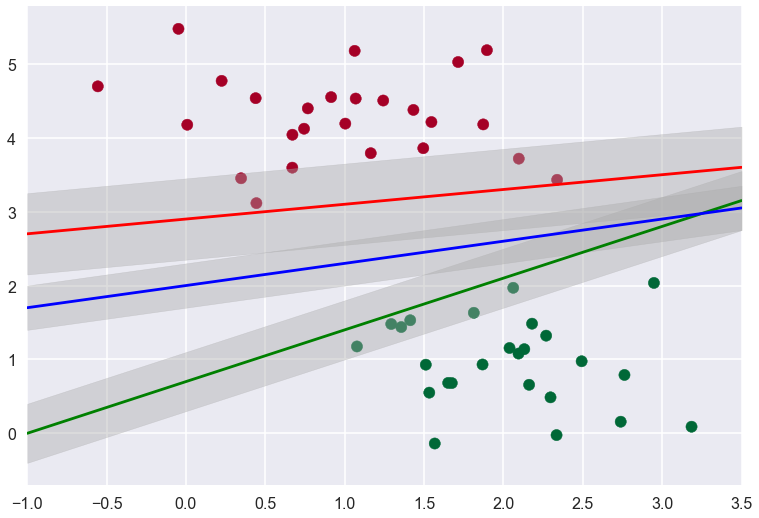

In [2]:
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=.6)

xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=COLOR_MAP)

colors=['g','r','b']
# Рисуем три линии разделяющие сгенерированные данные
for ind, item in enumerate([(.7, .7, .4), (0.2, 2.9, 0.55),(0.3, 2, .3)]):
    k, b, d = item
    yfit = k * xfit + b
    plt.plot(xfit, yfit, '-k',color=colors[ind])
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In [3]:
import warnings
warnings.simplefilter('ignore')
def plot_svc_decision_function(clf, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='b', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

Строим плоскость максимизирующую расстрояние от двух опорных плоскостей классов(линии опорных векторов в sklearn.svm.SVC это атрибут `support_vectors_`)

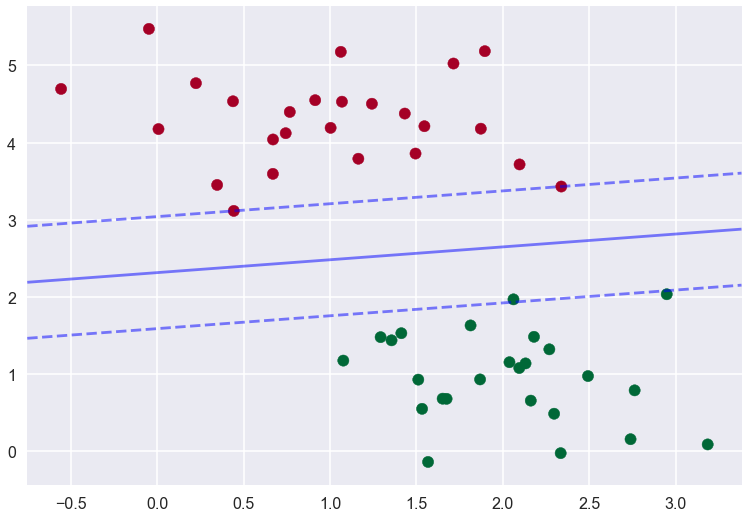

In [4]:
clf = SVC(kernel='linear')
clf.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=COLOR_MAP)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=200, facecolors='none');

In [5]:
def plot_svm(N=100, cluster_std=.6):
    X,y = make_blobs(n_samples=N, centers=2, random_state=0, cluster_std=cluster_std)
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=COLOR_MAP)
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200], cluster_std=(0,1.0));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), FloatSlider(value=0.6, description='cluster_std', max=1.0), Output()), _dom_classes=('widget-interact',))

Но что делать если данные линейно не разделимы? Рассмотрим два примера данных

In [6]:
def plotExamples():
    fig,axs=plt.subplots(2, sharex=True,figsize=(10,10))
    rng = np.random.RandomState(0)
    X = rng.randn(200, 2)
    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
    axs[0].scatter(X[:, 0], X[:, 1], c=y,s=40, cmap=COLOR_MAP);
    X_c, y_c = make_circles(200, factor=.4, noise=.1,random_state=42)
    axs[1].scatter(X_c[:, 0], X_c[:, 1], c=y_c,s=40, cmap=COLOR_MAP);

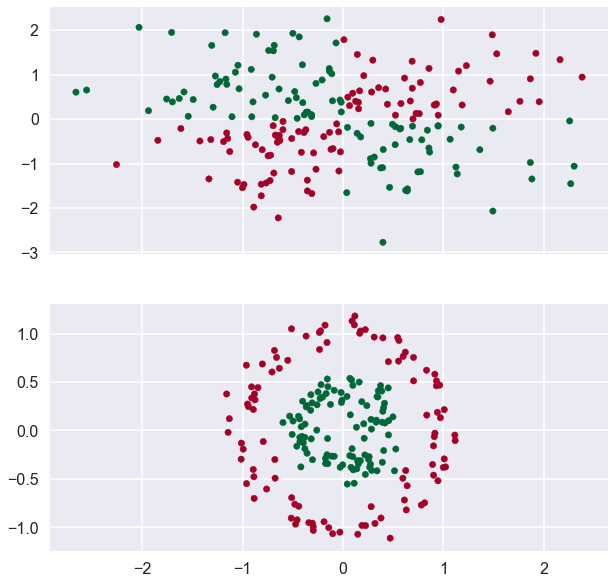

In [7]:
plotExamples()

### Ядра

#### Первый пример - "исключающее или"
Нельзя без ошибок поделить гиперплоскостью (или прямой, если это 2D) классы полученые "исключающим или", 
([the XOR problem](http://www.ece.utep.edu/research/webfuzzy/docs/kk-thesis/kk-thesis-html/node19.html)).

XOR – это булева функция со следующей таблицей истинности:

a| b| $a\oplus b$
--- | --- | ---
0|0|0
1|1|1
0|1|1
1|1|0

XOR дал имя простой задаче бинарной классификации, в которой классы представлены вытянутыми по диагоналям и пересекающимися облаками точек.



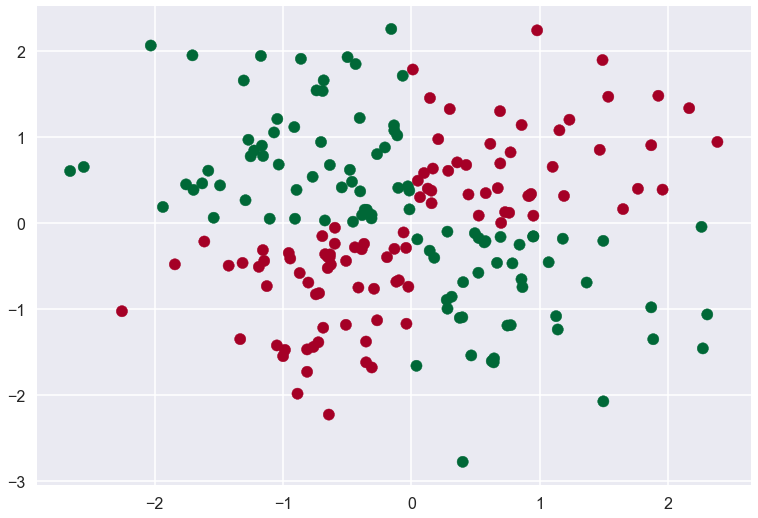

In [8]:
# порождаем данные
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=COLOR_MAP);

In [9]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
    np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), \
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=COLOR_MAP)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
#     plt.colorbar(image)
    plt.title(plot_title, fontsize=12);


Очевидно, нельзя провести прямую так, чтобы без ошибок отделить один класс от другого. Поэтому логистическая регрессия плохо справляется с такой задачей.

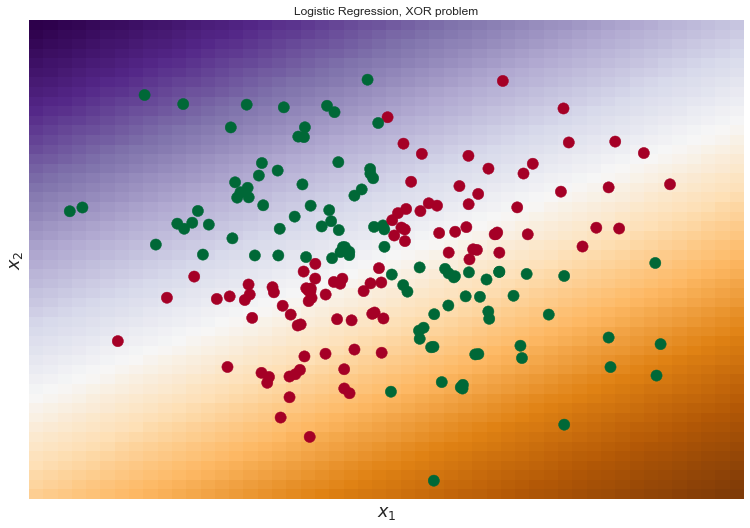

In [10]:
plot_boundary(LogisticRegression(), X, y, "Logistic Regression, XOR problem")

А вот если на вход подать полиномиальные признаки, в данном случае до 2 степени, то проблема решается.

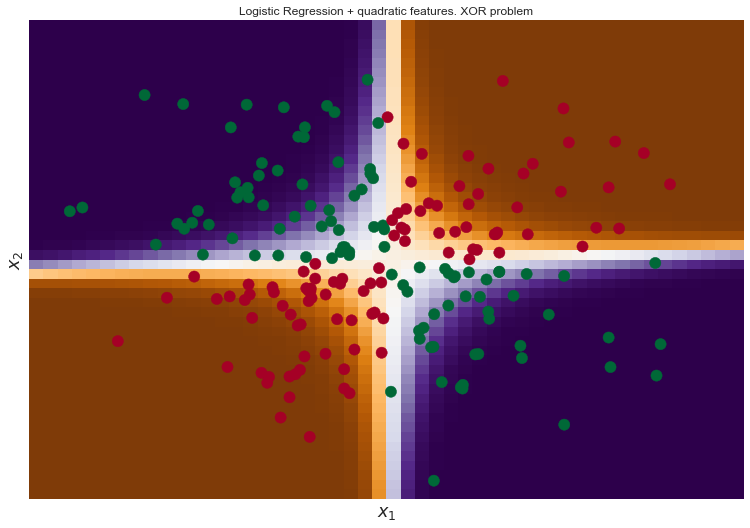

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), ('logit', LogisticRegression())])
plot_boundary(logit_pipe, X, y, "Logistic Regression + quadratic features. XOR problem")

На практике полиномиальные признаки действительно помогают, но строить их явно – вычислительно неэффективно. Гораздо быстрее работает SVM с ядровым трюком(прозванный в англоязычной литературе как kernel trick). При таком подходе в пространстве высокой размерности считается только расстояние между объектами (задаваемое функцией-ядром), а явно плодить комбинаторно большое число признаков не приходится.


#### Второй пример

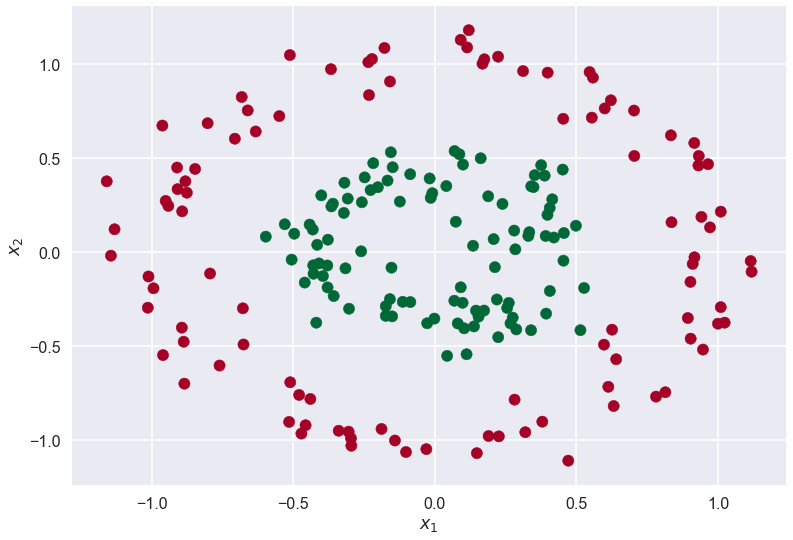

In [12]:
X_c, y_c = make_circles(200, factor=.4, noise=.1,random_state=42)
plt.scatter(X_c[:, 0], X_c[:, 1], c=y_c, cmap=COLOR_MAP);
plt.xlabel(r'$x_1$');
plt.ylabel(r'$x_2$');

В чем заключается kernel trick -  линейные методы можно применять и для восстановления нелинейных зависимостей, если предварительно перейти к новым признакам.  Подставляя вместо скалярного произведения функцию ядра, мы будем настраивать классификатор в произвольном признаковом пространстве.

В самом простом случае для данных нужно добавить новый признак, к примеру $x_3=x_1^2+x_2^2$ ,благодаря которому данные можно будет идеально разделить гиперплоскостью вида $x_3 = C$

Такое пространство называется _спрямляющим_. В новом признаковом пространствe разделяющая поверхность является линейной, однако после ее проецирования на исходное пространство она окажется нелинейной.


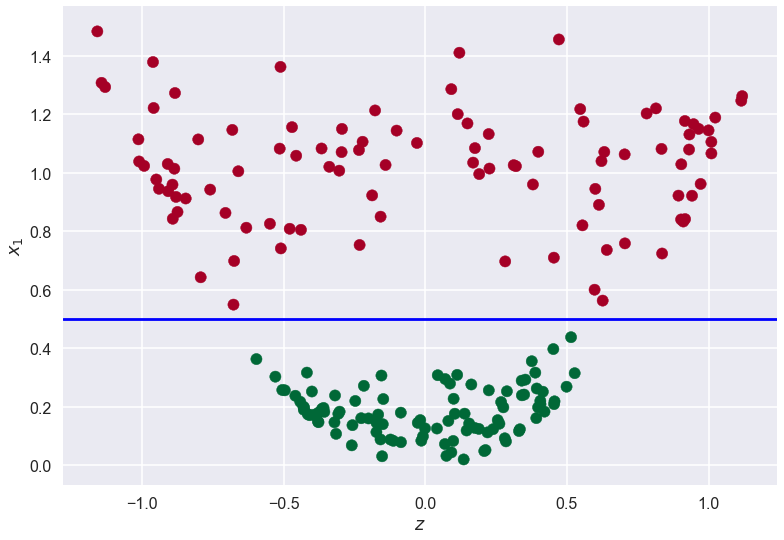

In [13]:
z_c=np.power(X_c[:, 0],2)+np.power(X_c[:, 1],2)
plt.scatter(X_c[:, 0], z_c, c=y_c, cmap=COLOR_MAP);
plt.axhline(y=.5, color='b', linestyle='-')
plt.xlabel(r'$z$')
plt.ylabel(r'$x_1$');

Модель, в которой зависимость ищется как линейная комбинация нелинейных функций от выборки, называется _линейной моделью над базисными функциями_.

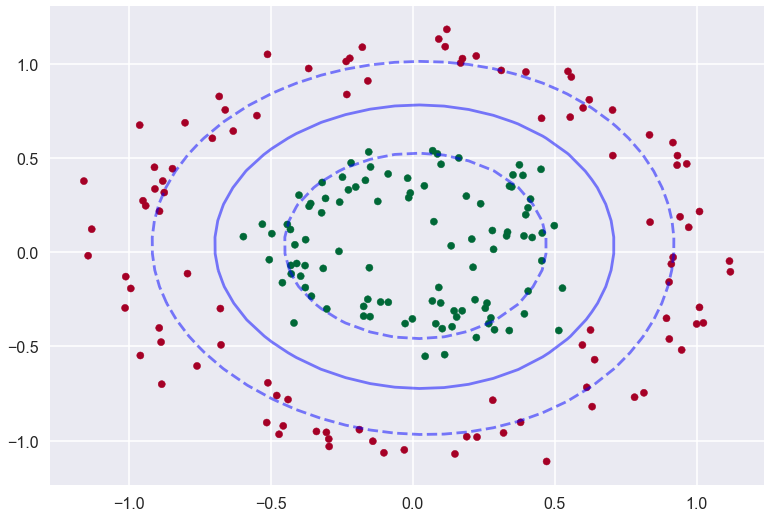

In [14]:
clf = SVC()
clf.fit(X_c, y_c)

plt.scatter(X_c[:, 0], X_c[:, 1], c=y_c, s=50, cmap=COLOR_MAP)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], facecolors='none');

In [15]:
# def plotcircle_3D(azimuth=3,elevation=1):
#     ax = plt.subplot(projection='3d')
#     ax.scatter3D(X_c[:, 0], X_c[:, 1], z_c, c=y_c, s=50, cmap=COLOR_MAP)
#     ax.view_init(elev=elevation, azim=azimuth)
#     yy, xx = np.meshgrid(np.linspace(-1,1,11), np.linspace(-1,1,11))
#     ax.plot_surface(xx, yy, np.full((1,11),.5))
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('z')
# interact(plotcircle_3D, elevation=[-90, 90], azimuth=(-180, 180));

Вернемся к первому примеру.

Для добавления нового параметра в данные XOR характера используется радиально базисная функция Гауса ([RBF](https://en.wikipedia.org/wiki/Radial_basis_function)):
    $$f(r)=\exp^{-(\varepsilon r)^2}$$
    $$r=||x_1-x_2||$$
    $$x_3 = f(r)$$

И тогда характер разделения данных можно условно обозначить через плотность [расспределения Гауса](http://ru.math.wikia.com/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5)
$$\frac{1}{\sigma\sqrt{2\pi}}\exp{\bigg( - \frac{{(x-\mu)}^2}{2\sigma^2}\bigg)}$$

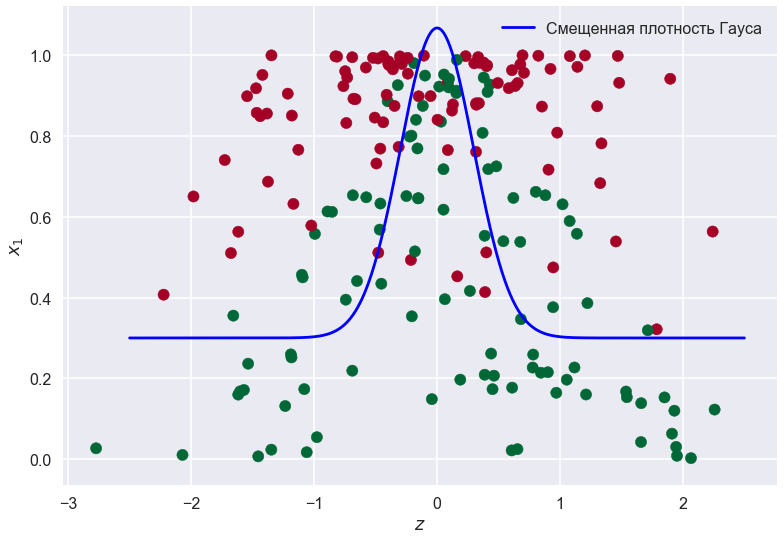

In [16]:
def gaussian(x, mu, sig,c):
    return .3+1./(np.sqrt(2*c*math.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

gamma=.6
norm=np.abs(X[:, 0] - X[:, 1])
z = np.exp(-(gamma*norm) **2)
plt.scatter(X[:, 1], z, c=y, cmap=COLOR_MAP);
gaussian_x = np.arange(-2.5, 2.5, 0.001)
plt.plot(gaussian_x, gaussian(gaussian_x,0,.3,3),color='b', linestyle='-', label='Смещенная плотность Гауса')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$x_1$');

#### Что такое гамма ядра?

In [17]:
norm=np.abs(X[:, 0] - X[:, 1])
def plot_3D(elevation=30, azimuth=30,gamma=1):
    #r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))
    z = np.exp(-(gamma*norm) **2)
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], z, c=y, s=50, cmap=COLOR_MAP)
    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

interact(plot_3D, elevation=(-90, 90), azimuth=(-180, 180),gamma=(.1,3.0));

interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-90), IntSlider(value=30, description='azimuth', max=180, min=-180), FloatSlider(value=1.0, description='gamma', max=3.0, min=0.1), Output()), _dom_classes=('widget-interact',))

Говоря простыми словами, gamma - это ширина ядра (kernel). Она участвует в подгонке модели и может являться причиной переобучения. Рассмотрим поведение нашего классификатора при разных значениях gamma

In [18]:
def plotXor(kernel='rbf',gamma=.6, c=1.):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=COLOR_MAP)
    clf = SVC(kernel=kernel,gamma=gamma,C=c)
    clf.fit(X, y)
    plot_svc_decision_function(clf)
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], facecolors='none');
interact(plotXor,kernel=['rbf','poly','linear','sigmoid'], gamma=(0.1, 3.0),c=(.1,2.));

interactive(children=(Dropdown(description='kernel', options=('rbf', 'poly', 'linear', 'sigmoid'), value='rbf'), FloatSlider(value=0.6, description='gamma', max=3.0, min=0.1), FloatSlider(value=1.0, description='c', max=2.0, min=0.1), Output()), _dom_classes=('widget-interact',))

Реализация SVM в пакете sklearn позволяет [использовать пользовательские ядра](http://scikit-learn.org/stable/modules/svm.html#custom-kernels), к примеру можно использовать стороние ядра из https://github.com/gmum/pykernels

In [19]:
class Kernel():
    
    def __init__(self, gamma=.6):
        self.gamma = gamma
    
    def _euclidean_dist_matrix(self, data_1, data_2):
        """
        Returns matrix of pairwise, squared Euclidean distances
        """
        norms_1 = (data_1 ** 2).sum(axis=1)
        norms_2 = (data_2 ** 2).sum(axis=1)
        return np.abs(norms_1.reshape(-1, 1) + norms_2 - 2 * np.dot(data_1, data_2.T))
    
    def __call__(self, X, Y):
        return np.exp(-self.gamma * self._euclidean_dist_matrix(X,Y))

    
def customKernel(gamma=.6, c=1.):
    clf = SVC(kernel=Kernel(gamma),C=c)
    
    clf.fit(X_c, y_c)

    plt.scatter(X_c[:, 0], X_c[:, 1], c=y_c, s=50, cmap=COLOR_MAP)
    plot_svc_decision_function(clf)
    plt.scatter(clf.support_vectors_[:],clf.support_vectors_[:], facecolors='none');

interact(customKernel, gamma=(0.1, 3.0),c=(.1,2.));

interactive(children=(FloatSlider(value=0.6, description='gamma', max=3.0, min=0.1), FloatSlider(value=1.0, description='c', max=2.0, min=0.1), Output()), _dom_classes=('widget-interact',))

### Мульти классовая классификация

Для мульти классовой классификации используется подход [один против всех(one-vs-all)](https://ru.coursera.org/learn/machine-learning/lecture/68Pol/multiclass-classification-one-vs-all)

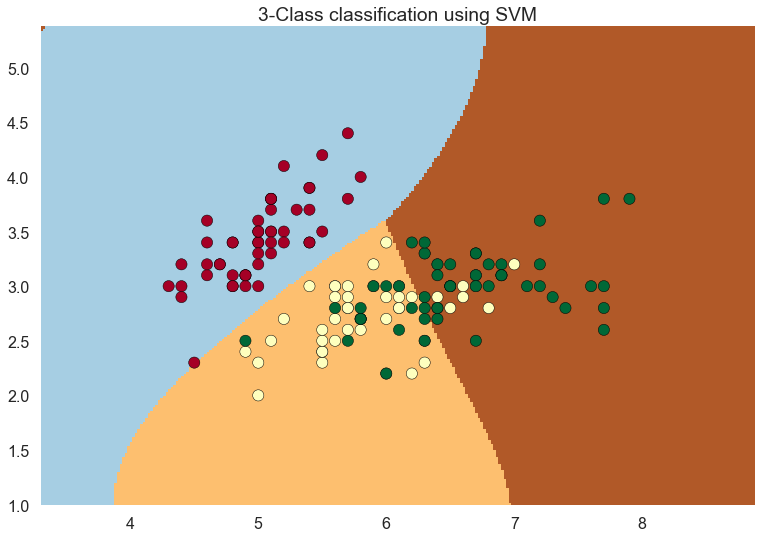

In [20]:
iris = load_iris()
X_i = iris.data[:, :2]
Y_i = iris.target

clf = SVC(decision_function_shape  ='ovr')
clf.fit(X_i, Y_i)

x_min, x_max = X_i[:, 0].min() - 1, X_i[:, 0].max() + 1
y_min, y_max = X_i[:, 1].min() - 1, X_i[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z_i = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z_i = Z_i.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z_i, cmap=plt.cm.Paired)

plt.scatter(X_i[:, 0], X_i[:, 1], c=Y_i, cmap=COLOR_MAP, edgecolors='k')
plt.title('3-Class classification using SVM');

## Регрессия

Для построения регрессии решается прямая задача минимизации функционала потерь, в предположении что решение задается линейной комбинацией неких порождающих функций, из которых можем составить вектор-функцию 
$$ f(x)=\begin{Vmatrix} f_1(x) \\ f_2(x)  \\ ... \\ f_k(x) \end{Vmatrix} $$

 Этот тип функции часто называют - функцией интенсивной эпсилон-потери.

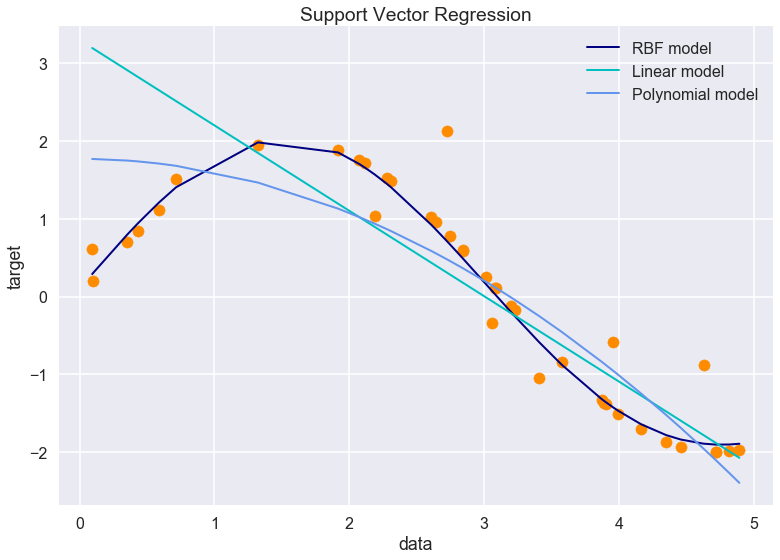

In [21]:
np.random.seed(0)
X_r = np.sort(5 * np.random.rand(40, 1), axis=0)
y_r = 2*np.sin(X_r).ravel()
# Add noise to targets
y_r[::5] += 3 * (0.5 - np.random.rand(8))

plt.scatter(X_r, y_r, color='darkorange')

colors = ['navy','c','cornflowerblue']
for indx, item in enumerate([
    {"model":SVR(kernel='rbf', C=1e3, gamma=0.1),'name':'RBF model'}, \
    {"model":SVR(kernel='linear', C=1e3),'name':'Linear model'}, \
    {"model":SVR(kernel='poly', C=1e3, degree=2),'name':'Polynomial model'}, \
                            ]):
    svr=item['model']
    name = item['name']
    y_pred_r = svr.fit(X_r, y_r).predict(X_r)
    plt.plot(X_r, y_pred_r, color=colors[indx], lw=2, label=name)


plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

## Преимущества и недостатки SVM:
- это наиболее быстрый метод нахождения решающих функций;
- метод сводится к решению задачи квадратичного программирования в выпуклой области, которая всегда имеет единственное решение;
- метод находит разделяющую полосу максимальной ширины, что позволяет в дальнейшем осуществлять более уверенную классификацию;
- метод чувствителен к шумам и стандартизации данных;
- не существует общего подхода к автоматическому выбору ядра (и построению спрямляющего подпространства в целом) в случае линейной неразделимости классов.

# Источники
- [Машина_опорных_векторов](http://www.machinelearning.ru/wiki/index.php?title=Машина_опорных_векторов)
- Материалы курса Евгения Соколова: ["Машинное обучение" на ФКН ВШЭ](https://github.com/esokolov/ml-course-hse)
    - [Линейная классификация](https://github.com/esokolov/ml-course-hse/blob/master/2017-fall/lecture-notes/lecture05-linclass.pdf)
    - [Преобразования признакового пространства](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture13-features.pdf)
- [Открытый курс машинного обучения. Тема 4. Линейные модели классификации и регрессии](https://habrahabr.ru/company/ods/blog/323890/)
- [C-Support Vector Classification](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [Epsilon-Support Vector Regression](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
- [A tutorial on support vector regression](https://web.cs.dal.ca/~tt/CSCI650806/projects/papers/SmolaSchoelkopf.pdf)